 # [Module 1.7] AutoGluon 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 데이터 로딩
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

## 데이터 세트 로딩

In [57]:
import pandas as pd

In [58]:
%store -r no_auto_train_file
# %store -r val_file
%store -r no_auto_test_file

In [59]:
train_pd = pd.read_csv(no_auto_train_file)
test_pd = pd.read_csv(no_auto_test_file)

In [60]:
print("auto_train_file: ", train_pd.shape)
print("auto_train_file: ", test_pd.shape)

auto_train_file:  (53740, 19)
auto_train_file:  (13436, 19)


In [61]:
from IPython.display import display as dp
dp(train_pd.head(2))
dp(test_pd.head(2))

,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_date,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,12030,taubate,SP,29.99,10.96,9000.0,fashion_shoes,13481,limeira,SP,2016-10-04 10:19:23,1,4,10,SP_SP,taubate_limeira,12030_13481,2640.0
1,2,78075,cuiaba,MT,23.90,26.82,1500.0,furniture_decor,17051,bauru,SP,2016-10-04 13:46:31,1,4,10,MT_SP,cuiaba_bauru,78075_17051,14625.0


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_date,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,2018-06-19 03:36:38,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,0,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,2018-06-19 03:36:39,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


In [62]:
import autogluon.core as ag
from autogluon.tabular import TabularPrediction as task

## 오토글루온 데이터 타입으로 변경

In [63]:
train_data = task.Dataset(file_path= no_auto_train_file)
subsample_size = train_data.shape[0]
# subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head())

Loaded data from: preproc_data/auto_no_fe/train.csv | Columns = 19 / 19 | Rows = 53740 -> 53740


       classes  customer_zip_code_prefix         customer_city customer_state  \
588          2                     83260              matinhos             PR   
45386        3                     84010          ponta grossa             PR   
9427         3                      3828             sao paulo             SP   
46834        2                     29370  conceicao do castelo             ES   
2383         3                     78070                cuiaba             MT   

        price  freight_value  product_weight_g product_category_name_english  \
588     59.99          18.00             525.0                sports_leisure   
45386  120.00          18.72            1300.0     construction_tools_lights   
9427   189.99          23.91           12675.0              office_furniture   
46834   49.99          18.23             500.0                 watches_gifts   
2383   174.90          16.92             375.0           luggage_accessories   

       seller_zip_code_prefix   

In [64]:
label_column = 'classes'
print("Summary of class variable: \n", train_data[label_column].describe())

Summary of class variable: 
 count    53740.000000
mean         2.178675
std          1.152687
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: classes, dtype: float64


## 오토글루운으로 훈련

In [65]:
%%time
dir = 'agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
# presets = 'best_quality'
presets = 'medium_quality_faster_train'

predictor = task.fit(train_data=train_data, label=label_column, 
                     output_directory=dir,
                     time_limits=time_limits,
                     presets=presets)



Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to agModels-predictClass/
AutoGluon Version:  0.0.15b20201025
Train Data Rows:    53740
Train Data Columns: 18
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [2, 3, 1, 0, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    61396.01 MB
	Train Data (Original)  Memory Usage: 36.88 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFe

CPU times: user 28min 58s, sys: 14min 11s, total: 43min 9s
Wall time: 3min 38s


## 테스트 데이터 로딩

In [66]:
test_data = task.Dataset(file_path= no_auto_test_file)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head())

Loaded data from: preproc_data/auto_no_fe/test.csv | Columns = 19 / 19 | Rows = 13436 -> 13436


   customer_zip_code_prefix   customer_city customer_state   price  \
0                     89219       joinville             SC  105.00   
1                      9950         diadema             SP   99.97   
2                     25963     teresopolis             RJ   76.99   
3                     21330  rio de janeiro             RJ   64.90   
4                     29090         vitoria             ES   75.00   

   freight_value  product_weight_g product_category_name_english  \
0          23.89            1000.0                 watches_gifts   
1          15.80             650.0                    housewares   
2          23.34            1850.0               books_technical   
3          15.55             200.0                    cool_stuff   
4          27.51            2550.0               furniture_decor   

   seller_zip_code_prefix     seller_city seller_state           order_date  \
0                   21840  rio de janeiro           RJ  2018-06-19 03:36:38   
1           

## 모델 예측

In [67]:
predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.4505061030068473
Evaluations on test data:
{
    "accuracy": 0.4505061030068473,
    "accuracy_score": 0.4505061030068473,
    "balanced_accuracy_score": 0.4275448220167023,
    "matthews_corrcoef": 0.268146387541431
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.5866842452208306,
        "recall": 0.5219941348973607,
        "f1-score": 0.5524518932340161,
        "support": 1705
    },
    "1": {
        "precision": 0.5199004975124378,
        "recall": 0.3515136953387794,
        "f1-score": 0.4194380733944954,
        "support": 4162
    },
    "2": {
        "precision": 0.46519398552069796,
        "recall": 0.5525909592061742,
        "f1-score": 0.5051400927232412,
        "support": 4535
    },
    "3": {
        "precision": 0.3508388037928519,
        "recall": 0.4437269372693727,
        "f1-score": 0.3918533604887983,
        "support": 2168
    },
    "4": {
        "precision": 0.23770491803278687,


Predictions:   [2 2 2 ... 0 0 0]


## 리더 보드 생성

In [68]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatboostClassifier,0.473951,0.4632,0.096108,0.061951,5.526146,0.096108,0.061951,5.526146,0,True,10
1,RandomForestClassifierEntr,0.468592,0.4564,0.890911,0.114325,4.963329,0.890911,0.114325,4.963329,0,True,5
2,RandomForestClassifierGini,0.456684,0.4552,1.006819,0.114202,2.363406,1.006819,0.114202,2.363406,0,True,4
3,weighted_ensemble_k0_l1,0.450506,0.4848,13.312491,2.504974,162.014419,0.070395,0.000888,0.614595,1,True,12
4,LightGBMClassifierCustom,0.449315,0.4660,0.129616,0.041748,4.626267,0.129616,0.041748,4.626267,0,True,11
5,LightGBMClassifierXT,0.446636,0.4760,0.111821,0.040991,2.063390,0.111821,0.040991,2.063390,0,True,9
6,ExtraTreesClassifierGini,0.444999,0.4484,2.142941,0.113184,1.381922,2.142941,0.113184,1.381922,0,True,6
7,ExtraTreesClassifierEntr,0.443436,0.4500,2.551584,0.114788,1.887380,2.551584,0.114788,1.887380,0,True,7
8,LightGBMClassifier,0.437109,0.4668,0.048184,0.030767,1.246939,0.048184,0.030767,1.246939,0,True,8
9,KNeighborsClassifierUnif,0.333433,0.3292,0.328350,0.107862,0.064815,0.328350,0.107862,0.064815,0,True,2


## 모델 평가

In [69]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.45%
f1_score: 0.42%


[[ 890  541  253   16    5]
 [ 347 1463 1637  615  100]
 [ 204  533 2506  888  404]
 [  54  219  698  962  235]
 [  22   58  293  261  232]]


<Figure size 432x288 with 0 Axes>

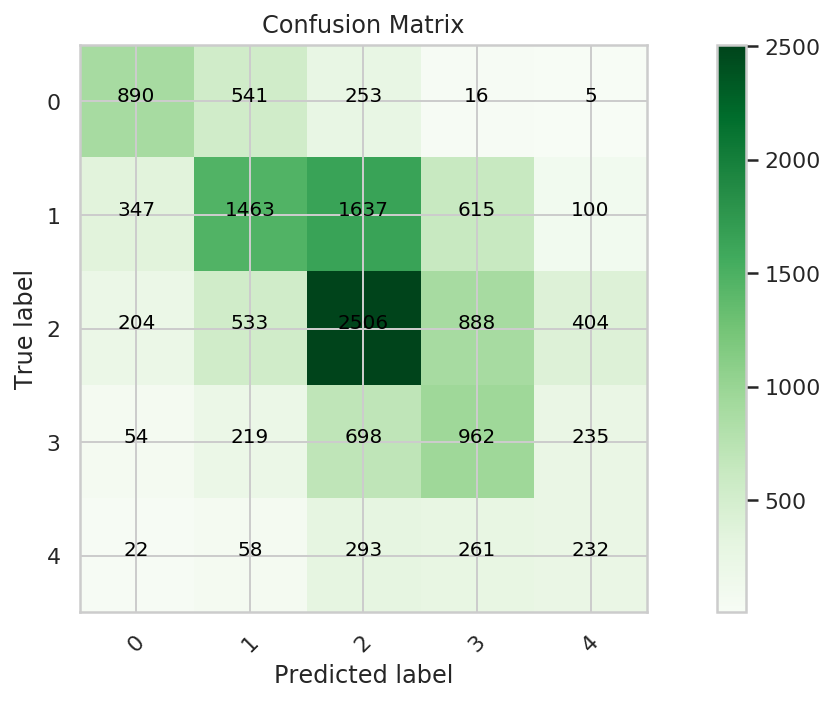

In [70]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

Computing raw permutation importance for 18 features on weighted_ensemble_k0_l1 ...
	110.25s	= Expected runtime
	109.33s	= Actual runtime


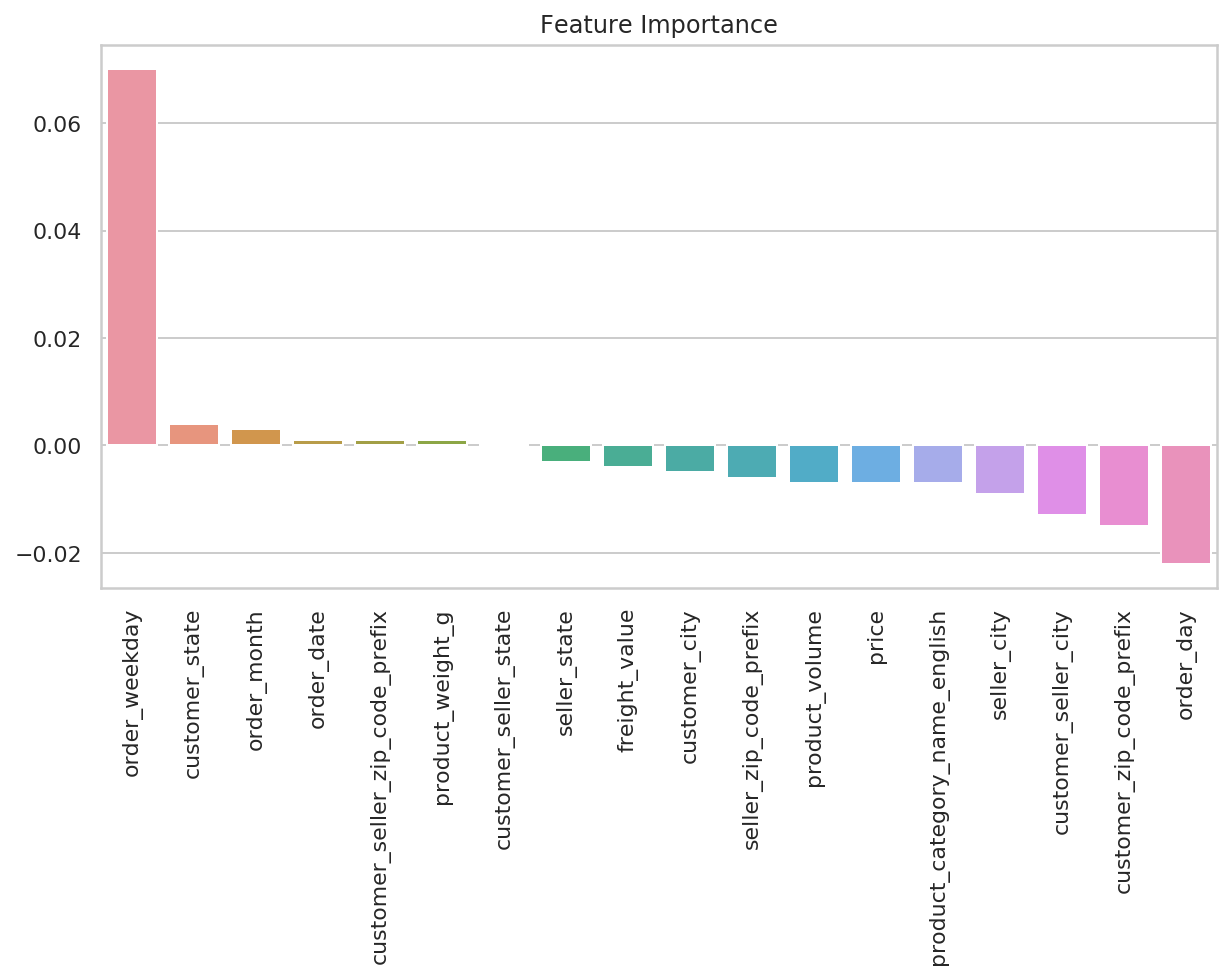

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()